In [1]:
# Import libraries
import time as time
import warnings
import seaborn as sns

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

az.style.use("arviz-darkgrid")
warnings.filterwarnings("ignore")

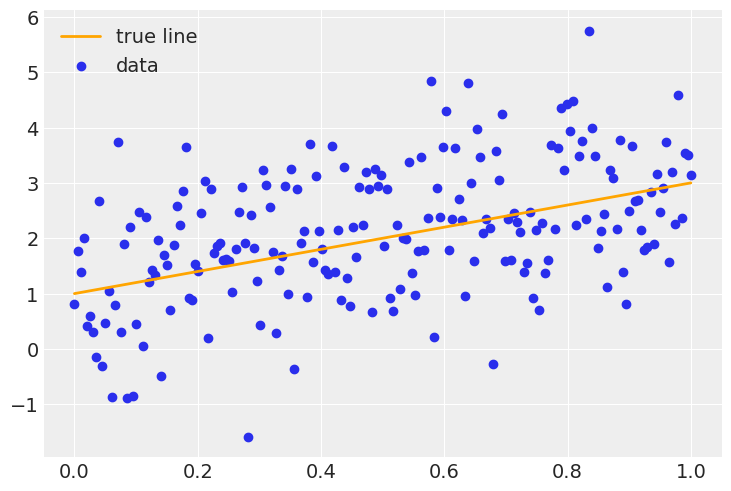

In [2]:
# Generate the data
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

true_intercept = 1
true_slope = 2
sigma = 1

size = 200
x = np.linspace(0, 1, size)
y = true_intercept + true_slope * x + np.random.normal(0, sigma ** 2, size)

# Plot the data
fig1, ax1 = plt.subplots(1,1)
ax1.scatter(x, y, label='data')
ax1.plot(x, true_intercept + true_slope * x, color = 'orange', label='true line', lw=2)
plt.legend(loc=0)

In [3]:
# Constructing the fine model

with pm.Model() as fine_model:
    # Define priors
    intercept = pm.Normal("intercept", 0, sigma=20)    # prior for the intercept 
    slope = pm.Normal("slope", 0, sigma=20)            # prior for the slope

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

# Thinning the data set
x_coarse = x[::2]    # takes by 2 elements of x 
y_coarse = y[::2]    # takes by 2 elements of x 

# Constructing the coarse model
with pm.Model() as coarse_model:
    # Define priors
    intercept = pm.Normal("intercept", 0, sigma=20)    # prior for the intercept
    slope = pm.Normal("slope", 0, sigma=20)            # prior for the slope

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x_coarse, sigma=sigma, observed=y_coarse)

In [4]:
# Draw MCMC samples
with fine_model:
    # Initialise step methods
    step = pm.MLDA(coarse_models=[coarse_model], subsampling_rates=[10])
    step_2 = pm.Metropolis()
    step_3 = pm.DEMetropolisZ()

    # remarks
    # draws: number of draws from the posterior
    # tune: number of initial draws discarded
    # step: the method I use

    # Sample using MLDA
    t_start = time.time()
    trace = pm.sample(draws=5000, chains=4, tune=1000, step=step, random_seed=RANDOM_SEED, progressbar=True)
    runtime = time.time() - t_start

    """
    # Sample using Metropolis
    t_start = time.time()
    trace_2 = pm.sample(draws=6000, chains=4, tune=2000, step=step_2, random_seed=RANDOM_SEED)
    runtime_2 = time.time() - t_start

    # Sample using DEMetropolisZ
    t_start = time.time()
    trace_3 = pm.sample(draws=6000, chains=4, tune=2000, step=step_3, random_seed=RANDOM_SEED)
    runtime_3 = time.time() - t_start
    """

Multiprocess sampling (4 chains in 4 jobs)
MLDA: [slope, intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

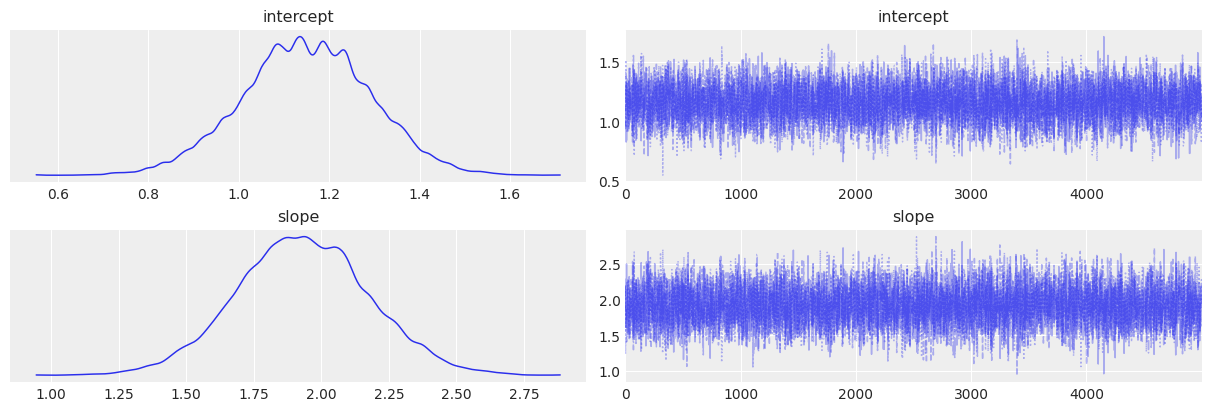

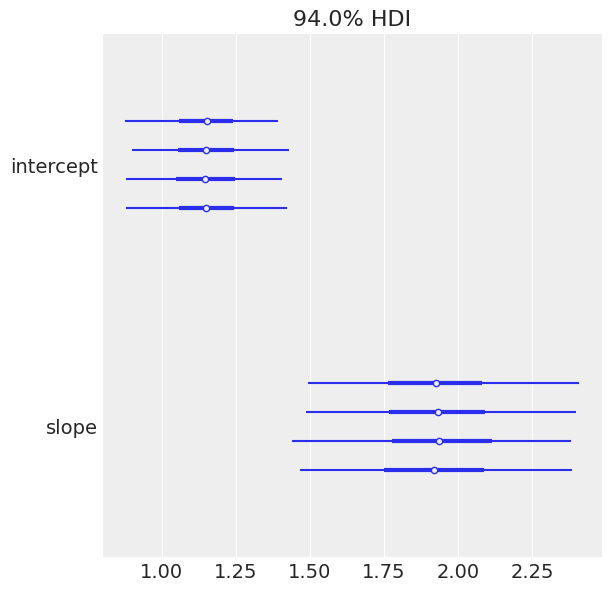

In [5]:
# do the plot of the trace
az.plot_trace(trace, combined=True)
# the four lines are the sampling from the four chains
# if combined = true, I plot data all together

# do the plot of credibility intervals for all chains
az.plot_forest(trace)

In [6]:
# view the summary
az.summary(trace)
# mcse is the montecarlo standard error
# ess_bulk: useful measure for sampling efficiency in the bulk of the distribution (related e.g. to efficiency of estimates)
# ess_tail: minimum of effective sample sizes for 5% and 95% quantiles. Tail-ESS is useful measure for sampling efficiency in the tails of the distribution
# r_hat: necessary condition for convergence, must be less than 1.05-1-1

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.149,0.141,0.875,1.407,0.002,0.001,6240.0,6503.0,1.0
slope,1.930,0.245,1.462,2.385,0.003,0.002,6685.0,7265.0,1.0


In [7]:
# Make sure samplers have converged
assert all(az.rhat(trace) < 1.03)

Got error No model on context stack. trying to find log_likelihood in translation.


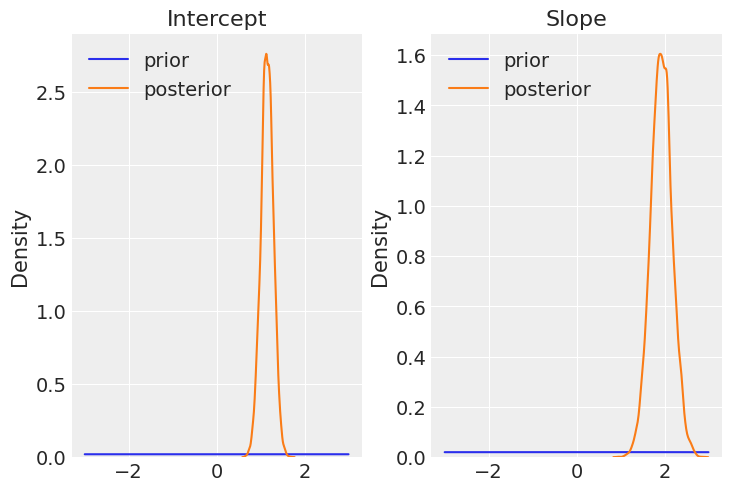

In [8]:
# Compare the densities of prior and posterior

from scipy.stats import norm

post_intercept = trace.get_values('intercept', burn=1000)    #set chains=i to get the results of chain i only, i=0,1,2,3
post_slope = trace.get_values('slope', burn=1000)
x_supp = np.linspace(-3,3,size)

fig2, ax2 = plt.subplots(1,2)
ax2[0].plot(x_supp, norm.pdf(x_supp,0,20), label='prior')
sns.distplot(post_intercept, ax=ax2[0], hist=False, kde=True, label='posterior')
# ax2[0].hist(post_intercept, density=True, bins=20, color='lightgray', edgecolor='black', label='posterior')

ax2[1].plot(x_supp, norm.pdf(x_supp,0,20), label='prior')
sns.distplot(post_slope, ax=ax2[1], hist=False, kde=True, label='posterior')
# ax2[1].hist(post_slope, density=True, bins=20, color='lightgray', edgecolor='black', label='posterior')

ax2[0].set_title('Intercept')
ax2[0].legend(loc='upper left')
ax2[1].set_title('Slope')
ax2[1].legend(loc='upper left')

# alternative
# az.plot_posterior(trace)


Got error No model on context stack. trying to find log_likelihood in translation.


array([<AxesSubplot:title={'center':'intercept'}>,
       <AxesSubplot:title={'center':'slope'}>], dtype=object)

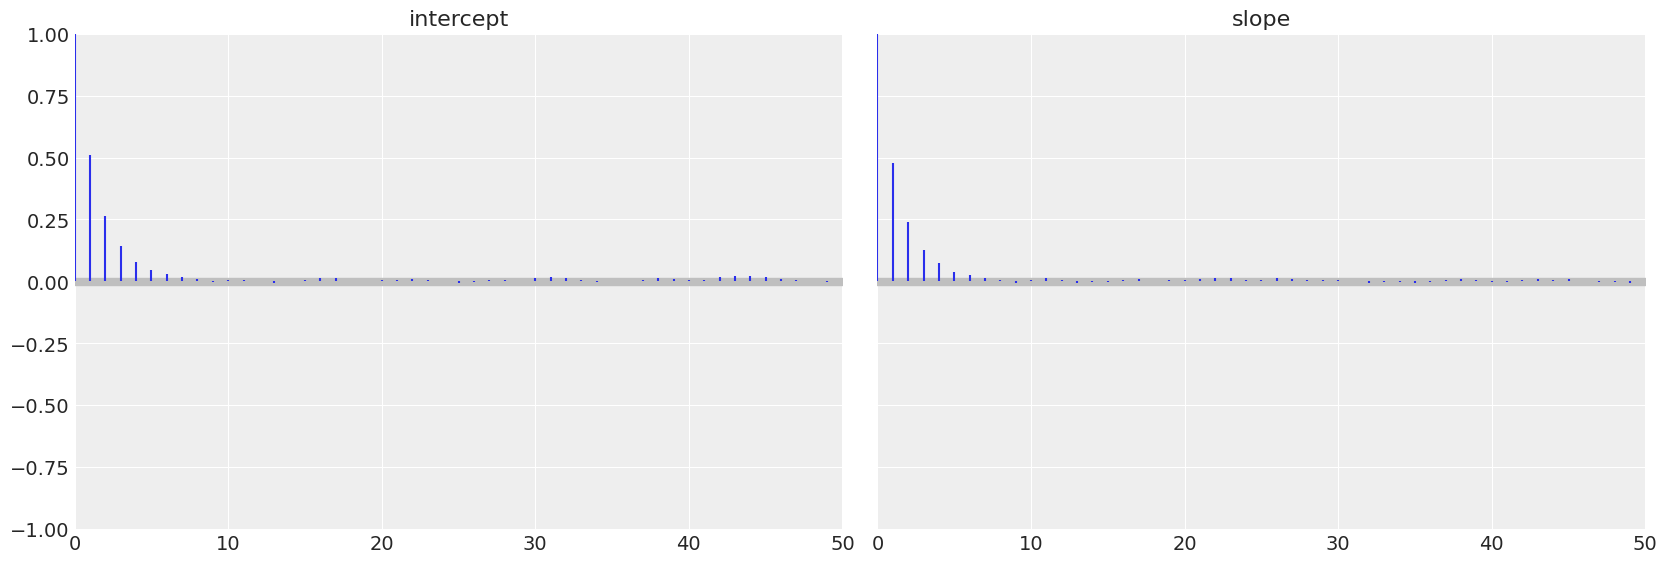

In [9]:
# Autocorrelation plot

az.plot_autocorr(trace, max_lag=50, combined=True)
# combined=False a plot for each chain
# max_lag=max T to compute the autocorr, default 100